### Policy Gradient Algorithms
See educational ressources:
https://spinningup.openai.com/en/latest/

In [1]:
import random
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
import itertools

In [2]:
#!git clone https://github.com/santmarti/SDIC-Code.git
#%cd SDIC-Code/notebooks

In [3]:
from Environment import Environment
from Environment import Environment, ACT_MODE, OBS_MODE
from Plotting import plotQ

In [4]:
class Softmax_wPolicy_class(object):

    def __init__(self, env, learning_rate=0.001):  
        self.learning_rate = learning_rate
        self.nactions = env.action_space.n

        obs = env.reset()
        if len(np.array(obs).shape) > 1:
            obs = np.array(obs).flatten()

        self.w = np.random.uniform(low=-0.01, high=0.01, size=(len(obs), self.nactions))

    def predict(self,s): 
        if len(np.array(s).shape) > 1:  # flatten for multidimensional
            s = np.array(s).flatten()

        z = s.dot(self.w)
        exp = np.exp(z)         # assuming temp of 1 : initial values need to be very small + learning rate
        exp = exp/np.sum(exp)

        return exp
    
    def act(self, s, epsilon=0):
        probs = self.predict(s)
        return np.random.choice(self.nactions, p=probs)
    
    def softmax_grad(self,probs,a):                  
        s = probs.reshape(-1,1)                      # equivalent to probs.flatten()
        J = np.diagflat(s) - np.dot(s, s.T)          # Vectorized softmax Jacobian
        return J[a]
    
    def score(self,s,a):
        probs = self.predict(s)
        dpolicy = self.softmax_grad(probs,a)      # Compute gradient and save with reward in memory for our weight updates
        pa = max(0.0000001, probs[a])
        dlog = dpolicy / pa
        if len(np.array(s).shape) > 1:  # flatten for multidimensional
            s = np.array(s).flatten()
        
        return s[None].T.dot(dlog[None])          # Score is same matrix shape as weights w
        
    def update_returns(self, states, actions, discounted_rewards):       
        for s,a,Gt in zip(states,actions,discounted_rewards):     
            target = self.score(s, a) * Gt
            self.w += self.learning_rate * target



In [5]:
def print_info(n, i_episode, num_episodes, epsilon, sum_rew, Q=None, steps=None):
    if(i_episode == 0): 
        print(str(i_episode)," Starting learning running ",num_episodes," episodes plotting every ", int(n)," episodes")  
        return 
    if(epsilon < 0):
        print(i_episode,"   Mean Reward: ",sum_rew)
    else:
        str_steps = "" if steps is None else " Steps: "+str(steps)
        str_Q = "" if Q is None else " Q states: "+str(Q.size())
        print(i_episode, " epsilon: %.1f"%epsilon, "   Mean Reward: %.1f"%sum_rew, str_steps, str_Q)


In [7]:
def episode_SARS_Tuples(env, policy, max_steps=10000):
    state = env.reset()
    states, actions, rewards, dones = [], [], [], []
    for i in itertools.count():                         
        action = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        states += [state]
        actions += [action]
        rewards += [reward]
        dones += [done]
        if done or i > max_steps: break       # run the episode till done or max_steps reached
        state = next_state
    return states, actions, rewards, dones


def Reinforce(env, learning_rate=0.1, discount_factor=0.95, num_episodes=5000, aPolicy_class=Softmax_wPolicy_class):
    env.history = {"episode_rew":[]}
    policy = aPolicy_class(env, learning_rate=learning_rate)        
    mean_rew_epi = 0
    for i_episode in range(num_episodes):
                                     
        states,actions,rewards,dones = episode_SARS_Tuples(env,policy)
        mean_rew_epi += np.sum(rewards)
        
        Gt, discounted_rewards = 0, np.zeros(len(rewards))
        for i in reversed(range(len(rewards))):
            Gt = Gt * discount_factor + rewards[i]
            discounted_rewards[i] = Gt
        
        policy.update_returns(states,actions,discounted_rewards)

        env.history["episode_rew"] += [np.sum(rewards)]
        n = num_episodes/10
        if(i_episode % n == 0):
            print_info(n, i_episode, num_episodes, 0, mean_rew_epi/n) 
            mean_rew_epi = 0

    env.close()
    return policy 

In [8]:
env = Environment("CartPole-v1")
params = {"learning_rate":0.0002, "discount_factor":0.99, "num_episodes":1500}
policy_cart = Reinforce(env, **params, aPolicy_class=Softmax_wPolicy_class)
#plt.plot(env.history["episode_rew"])

Setting default max_steps per episode: 100000
CartPole-v1 is an openai gym registered environment
CartPole--1ag Discrete Action Space with Discrete(2)
0  Starting learning running  1500  episodes plotting every  150  episodes
150  epsilon: 0.0    Mean Reward: 29.0  
300  epsilon: 0.0    Mean Reward: 48.5  
450  epsilon: 0.0    Mean Reward: 104.6  
600  epsilon: 0.0    Mean Reward: 213.4  
750  epsilon: 0.0    Mean Reward: 235.0  
900  epsilon: 0.0    Mean Reward: 282.4  
1050  epsilon: 0.0    Mean Reward: 356.0  
1200  epsilon: 0.0    Mean Reward: 386.6  
1350  epsilon: 0.0    Mean Reward: 468.6  


Setting default max_steps per episode: 100000
LunarLander-v2 is an openai gym registered environment
LunarLander--1ag Discrete Action Space with Discrete(4)
0  Starting learning running  1500  episodes plotting every  150  episodes
150  epsilon: 0.0    Mean Reward: -149.4  
300  epsilon: 0.0    Mean Reward: -108.1  
450  epsilon: 0.0    Mean Reward: -95.4  
600  epsilon: 0.0    Mean Reward: -77.8  
750  epsilon: 0.0    Mean Reward: -59.5  
900  epsilon: 0.0    Mean Reward: -31.9  
1050  epsilon: 0.0    Mean Reward: -12.6  
1200  epsilon: 0.0    Mean Reward: -22.2  
1350  epsilon: 0.0    Mean Reward: 13.1  


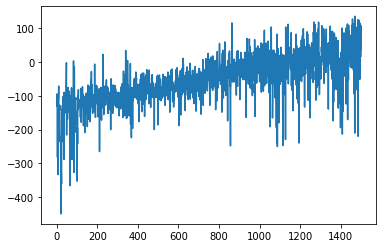

In [9]:
# For using LunarLander-v2 in gym you need to install library box2d 
# pip install box2d

env = Environment("LunarLander-v2")
params = {"learning_rate":0.0001, "discount_factor":0.99, "num_episodes":1500}
policy_lunar = Reinforce(env, **params, aPolicy_class=Softmax_wPolicy_class)
plt.plot(env.history["episode_rew"])

### Visualize Environment and policies

In [12]:
def run_episode(bRender=False, policy=None, aPolicy_class=Softmax_wPolicy_class):
    policy = aPolicy_class(env) if policy is None else policy    
    obs = env.reset()
    done, sum_reward = False, 0
    while not done:
        action = policy.act(obs)
        obs, rew, done, _ = env.step(action)
        sum_reward += rew
        if bRender:
            env.render()
    print("Episode ended sum_reward =",sum_reward)

In [15]:
env = Environment("CartPole-v1")
run_episode(bRender=True, policy=policy_cart)
env.close()

Setting default max_steps per episode: 100000
CartPole-v1 is an openai gym registered environment
CartPole--1ag Discrete Action Space with Discrete(2)
Episode ended sum_reward = 500.0


In [14]:
env = Environment("LunarLander-v2")
run_episode(bRender=True, policy=policy_lunar)
env.close()

Setting default max_steps per episode: 100000
LunarLander-v2 is an openai gym registered environment
LunarLander--1ag Discrete Action Space with Discrete(4)
Episode ended sum_reward = -28.17398359086181
